,begin,end,open,high,low,close,volume,value
0,2015-01-05 10:00:00,2015-01-05 10:59:59,23.350,23.970,23.235,23.450,1389900,32842584.0
1,2015-01-05 11:00:00,2015-01-05 11:59:59,23.470,23.765,23.470,23.745,1035700,24460278.0
2,2015-01-05 12:00:00,2015-01-05 12:59:59,23.735,24.250,23.685,24.205,1779400,42742529.5
3,2015-01-05 13:00:00,2015-01-05 13:59:59,24.205,24.230,23.845,23.845,1069600,25739506.0
4,2015-01-05 14:00:00,2015-01-05 14:59:59,23.835,23.980,23.810,23.810,578400,13806107.0


Размер датафрейма: (30157, 8)
Типы данных:
 begin      object
end        object
open      float64
high      float64
low       float64
close     float64
volume      int64
value     float64
dtype: object
Пропущенные значения:
 begin     0
end       0
open      0
high      0
low       0
close     0
volume    0
value     0
dtype: int64
Количество дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30157 entries, 0 to 30156
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   begin   30157 non-null  object 
 1   end     30157 non-null  object 
 2   open    30157 non-null  float64
 3   high    30157 non-null  float64
 4   low     30157 non-null  float64
 5   close   30157 non-null  float64
 6   volume  30157 non-null  int64  
 7   value   30157 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.8+ MB
Общая информация: None

Описательная статистика числовых переменных:
              count          mea

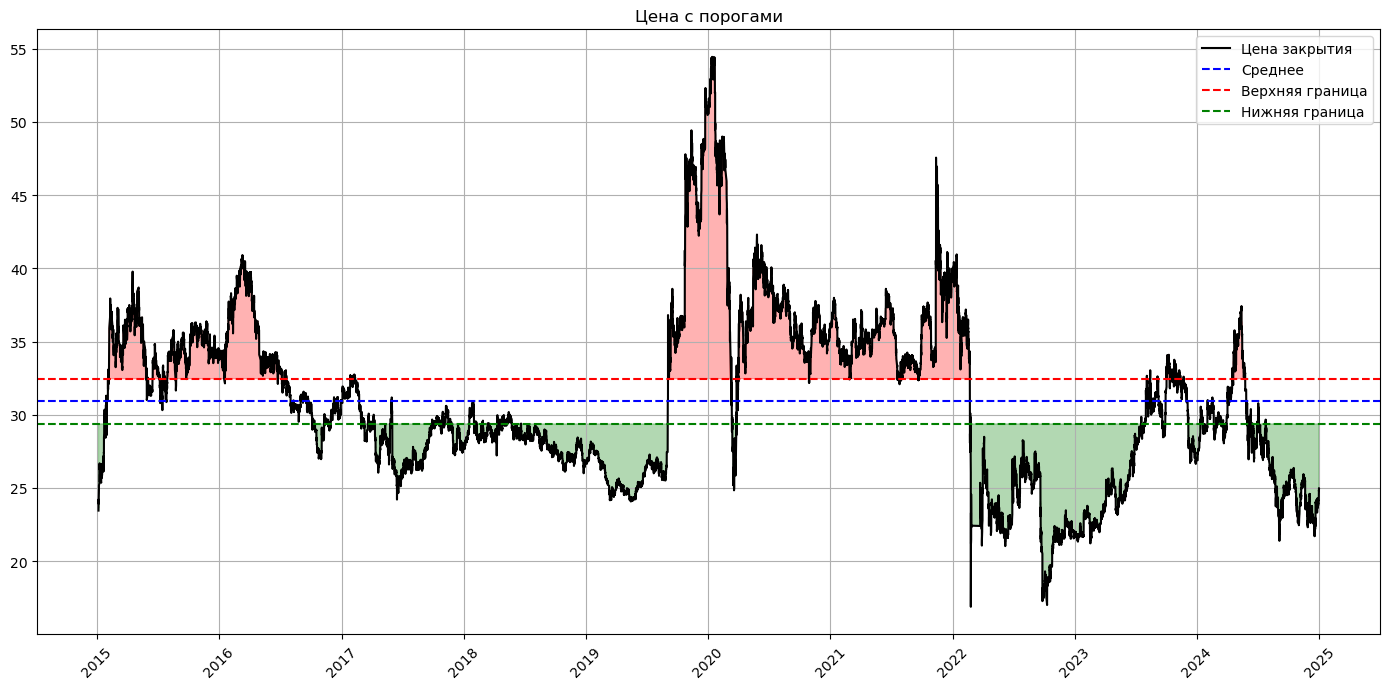

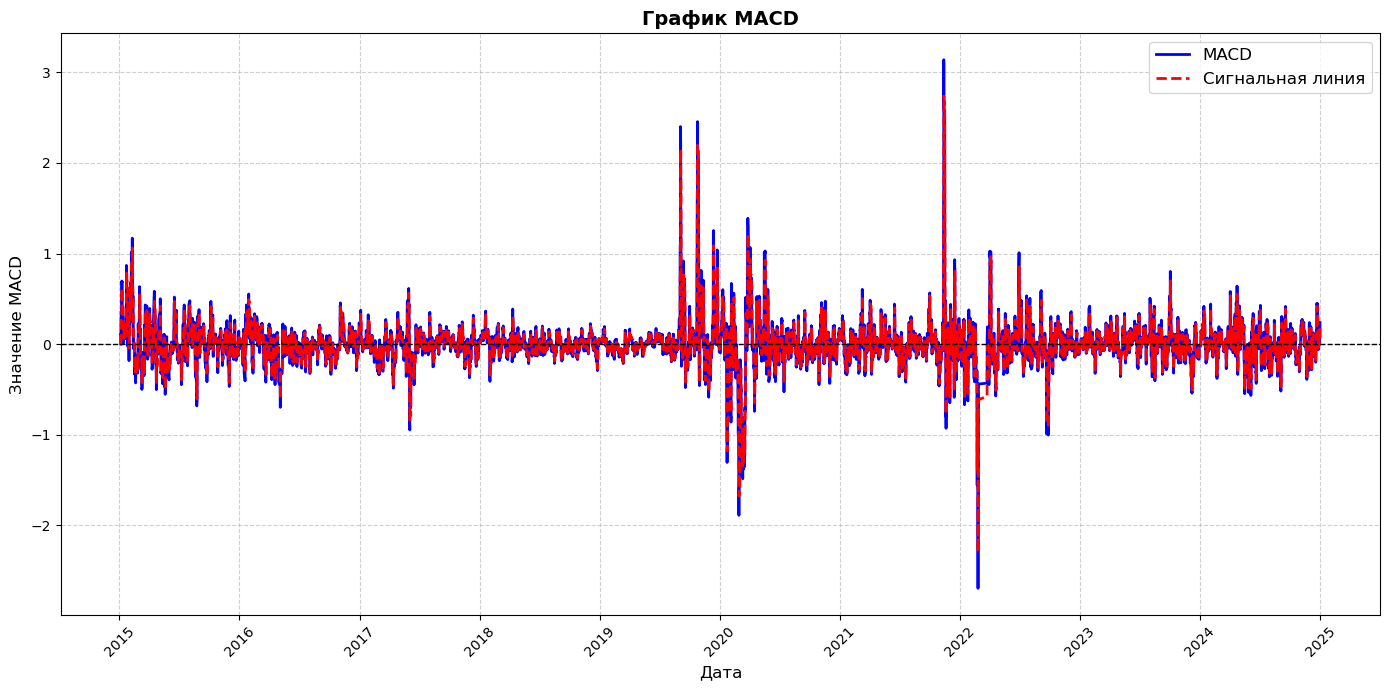

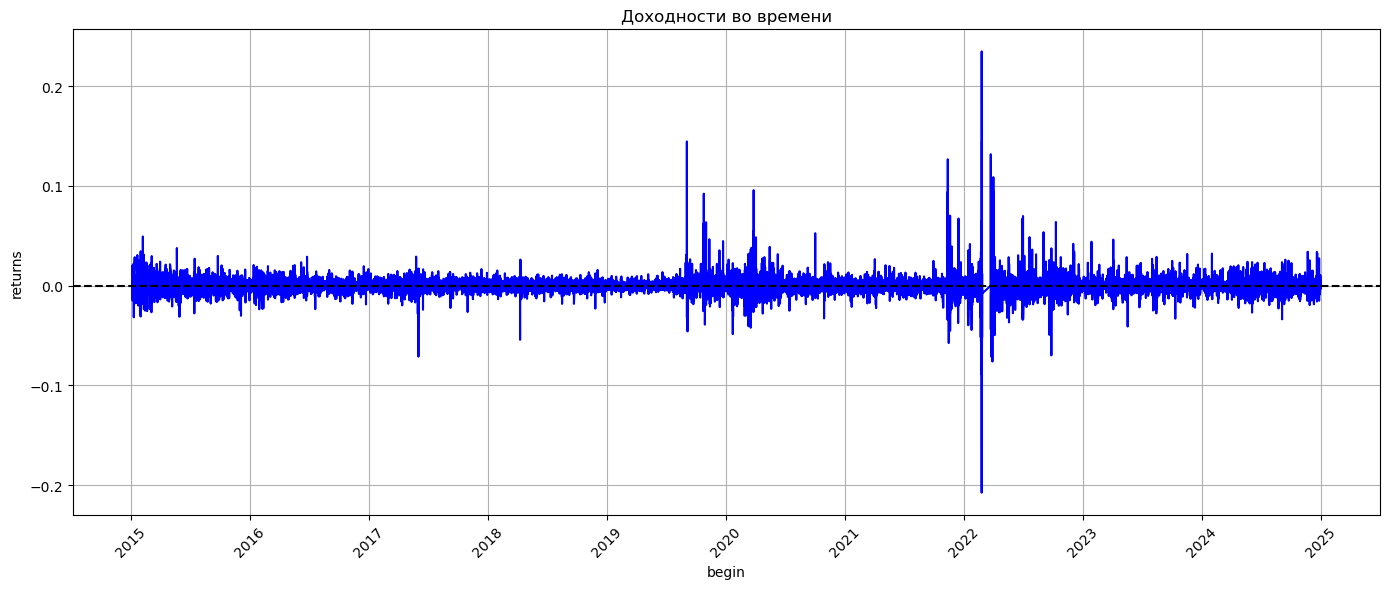

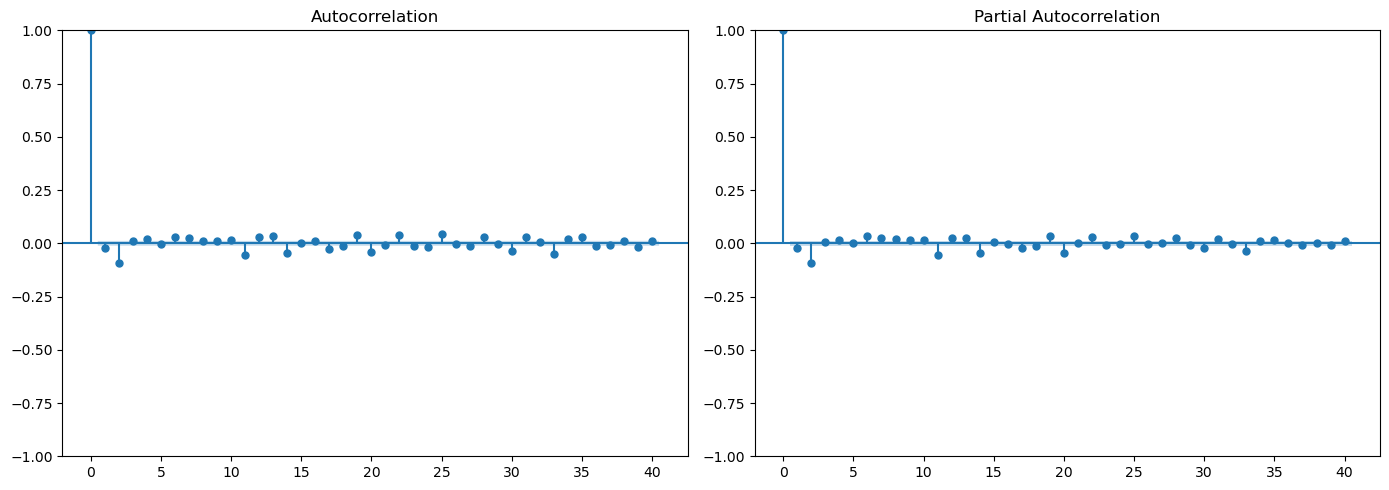

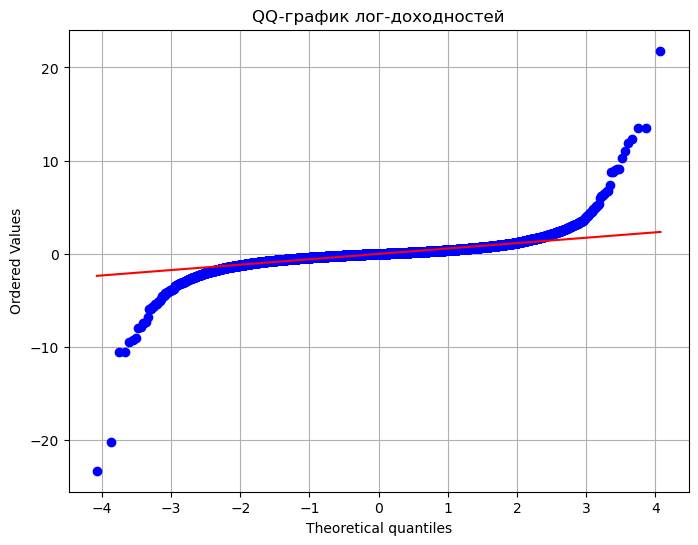

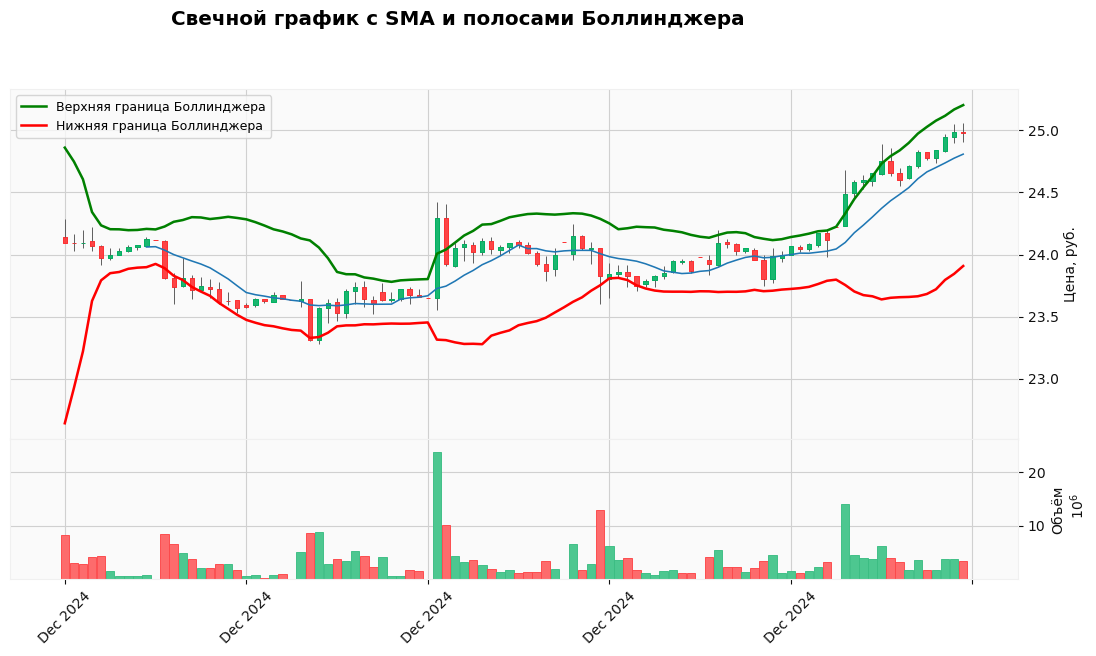

  ADF Тест: Проверка стационарности  
           лог-доходностей           
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Метрика                ┃ Значение ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ ADF-Statistic          │ -22.6559 │
│ p-value                │ 0.0000   │
│ Used Lags              │ 50       │
│ Number of Observations │ 30105    │
│ Critical Value (1%)    │ -3.4306  │
│ Critical Value (5%)    │ -2.8616  │
│ Critical Value (10%)   │ -2.5668  │
└────────────────────────┴──────────┘

   Jarque-Bera Тест: Проверка   
  нормальности лог-доходностей  
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Метрика      ┃ Значение      ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ JB Statistic │ 26968727.2682 │
│ p-value      │ 0.0000        │
└──────────────┴───────────────┘

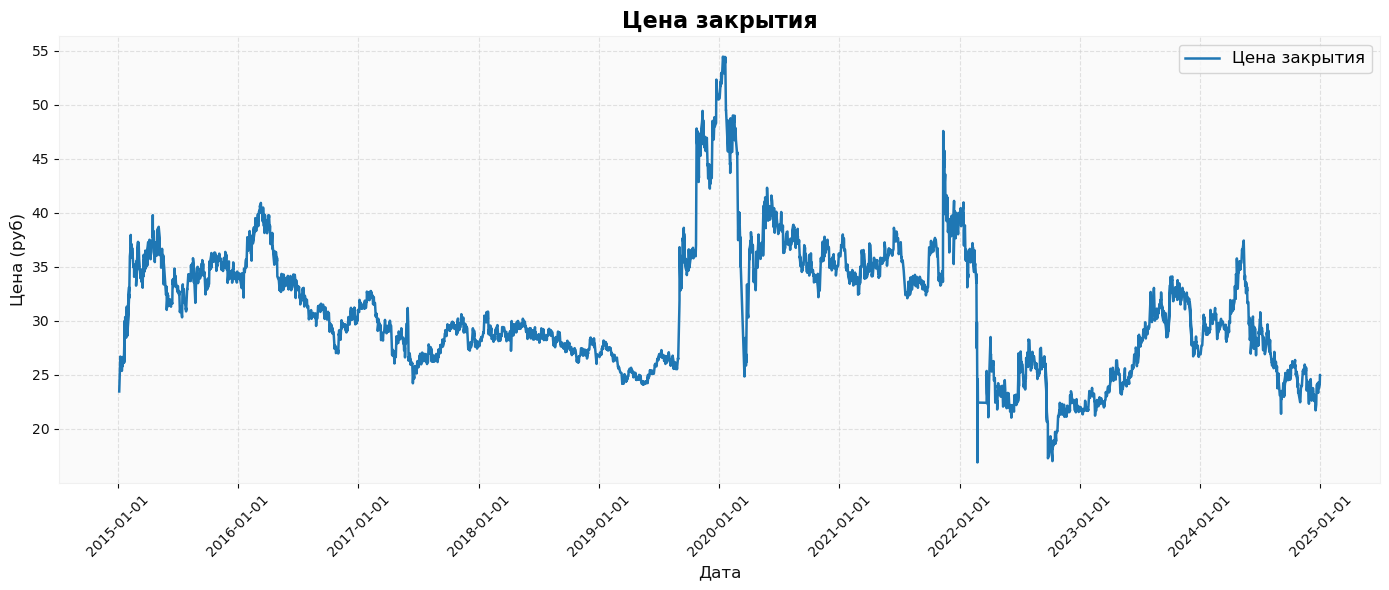

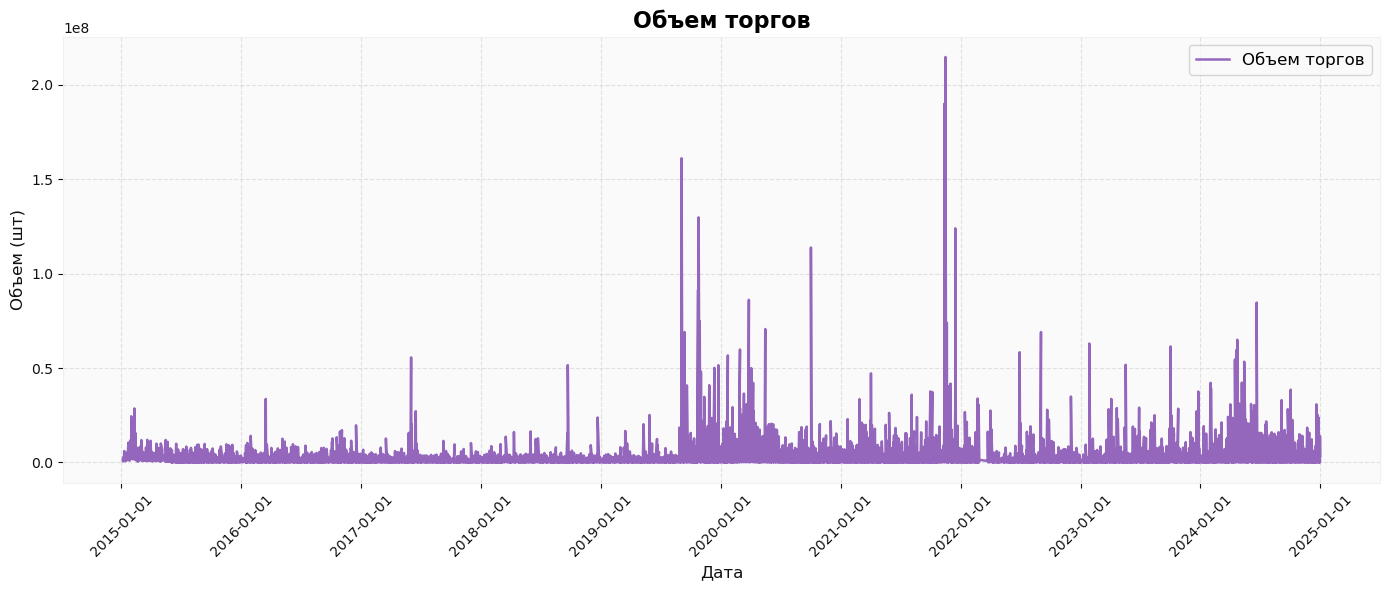

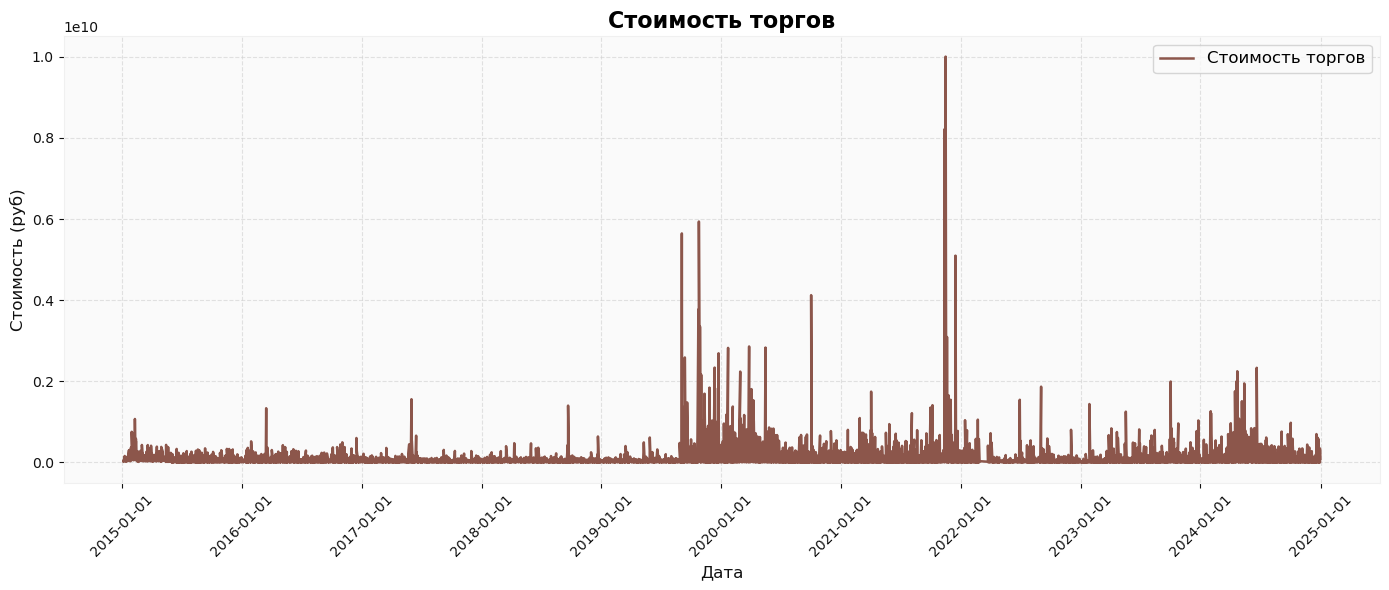

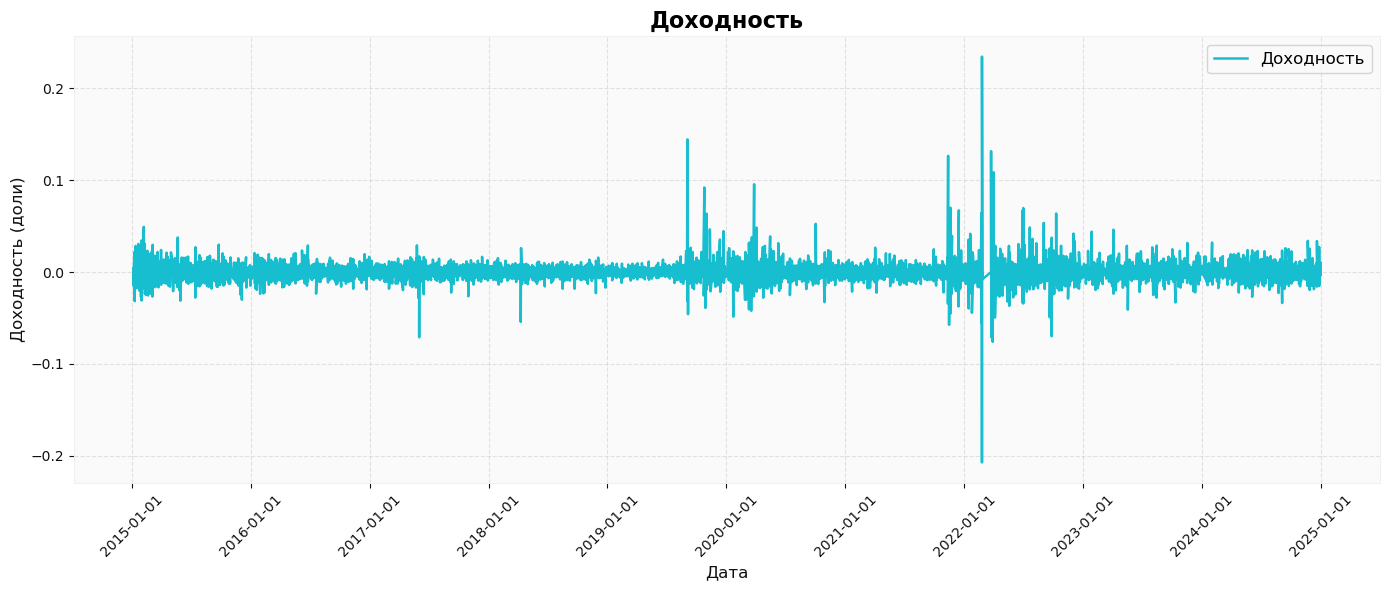

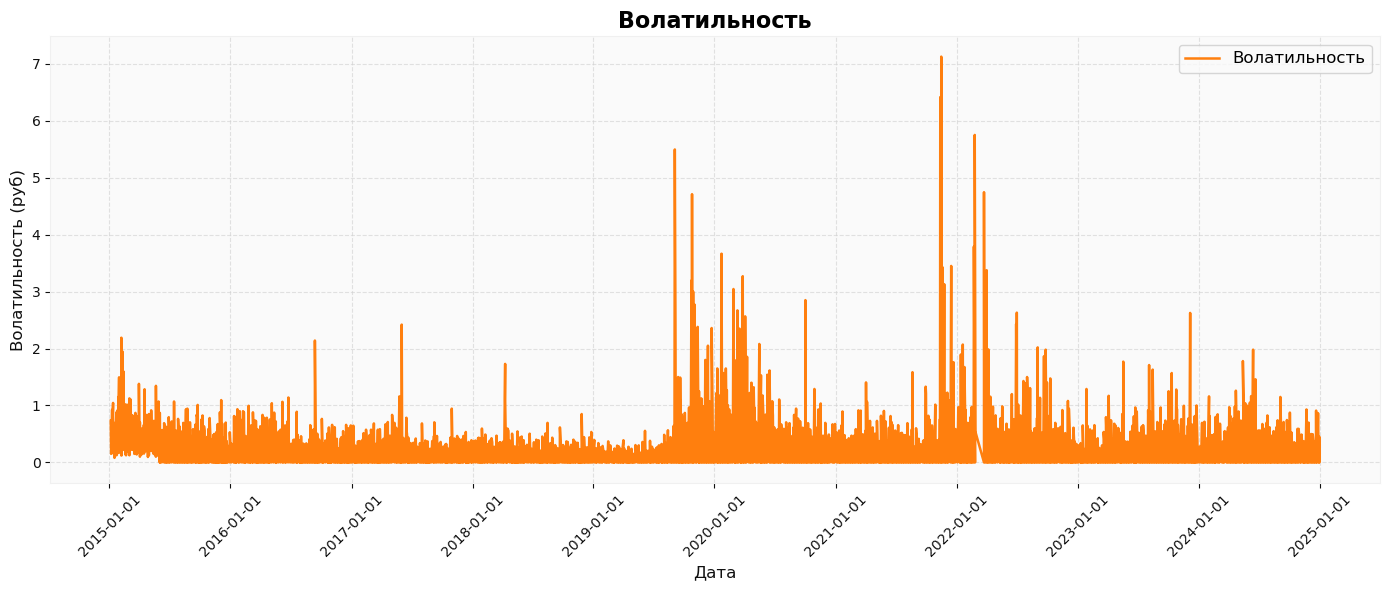

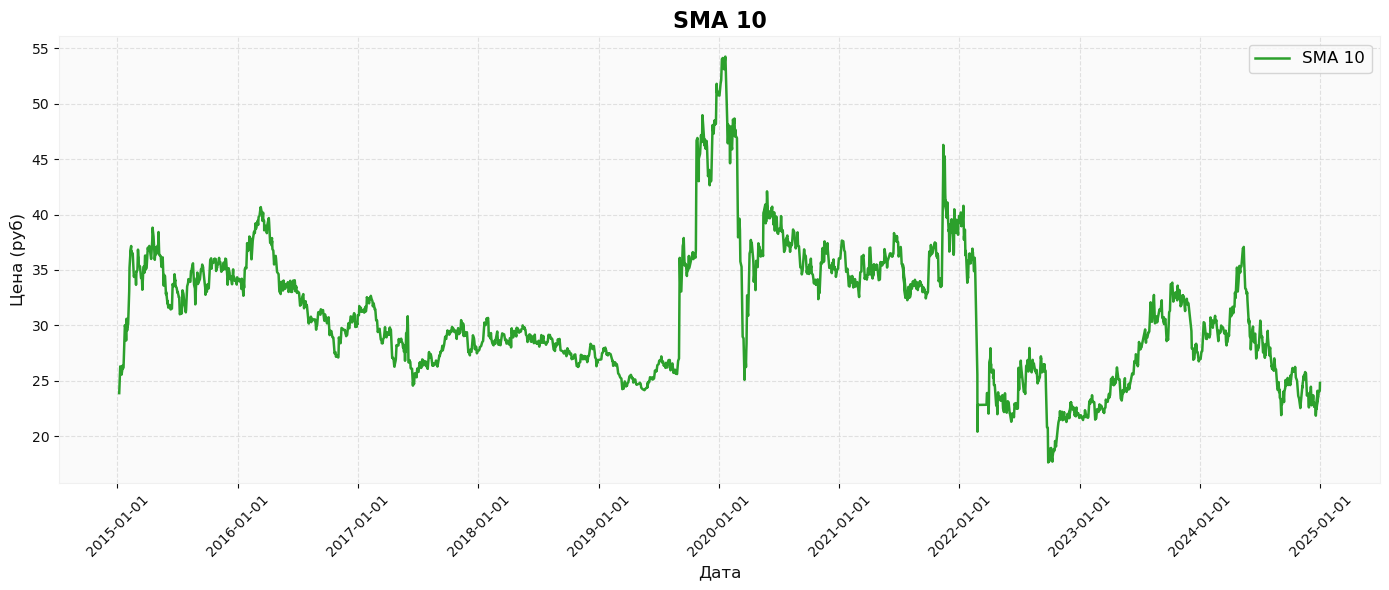

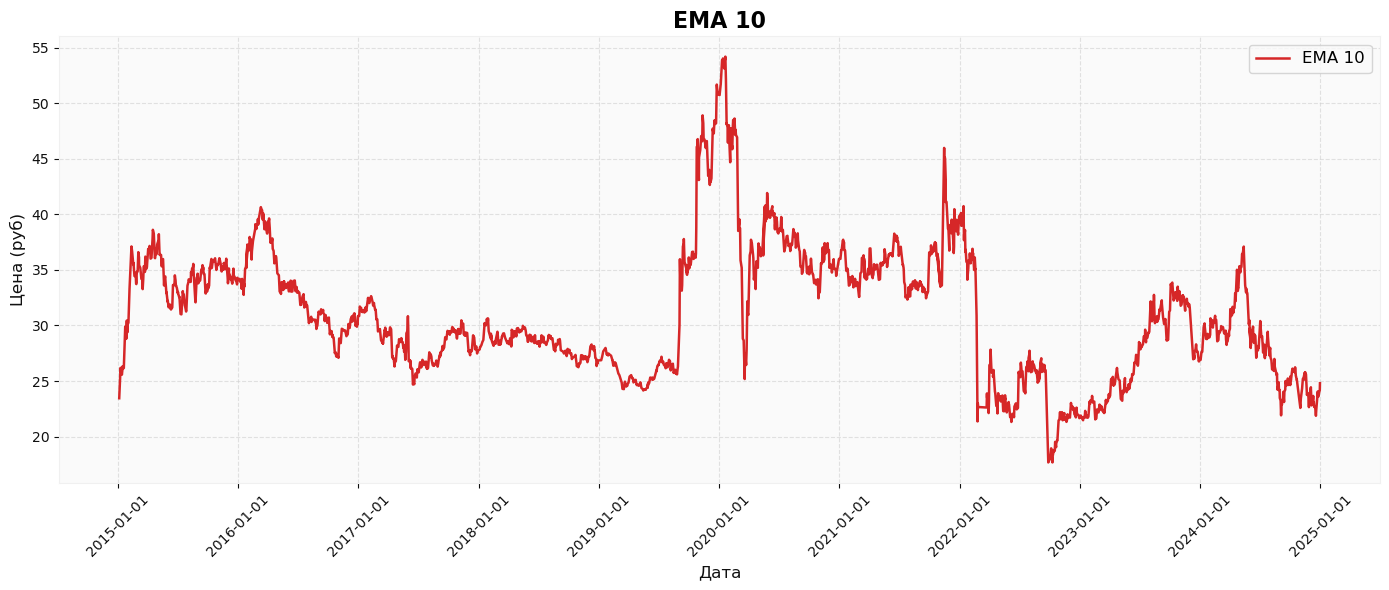

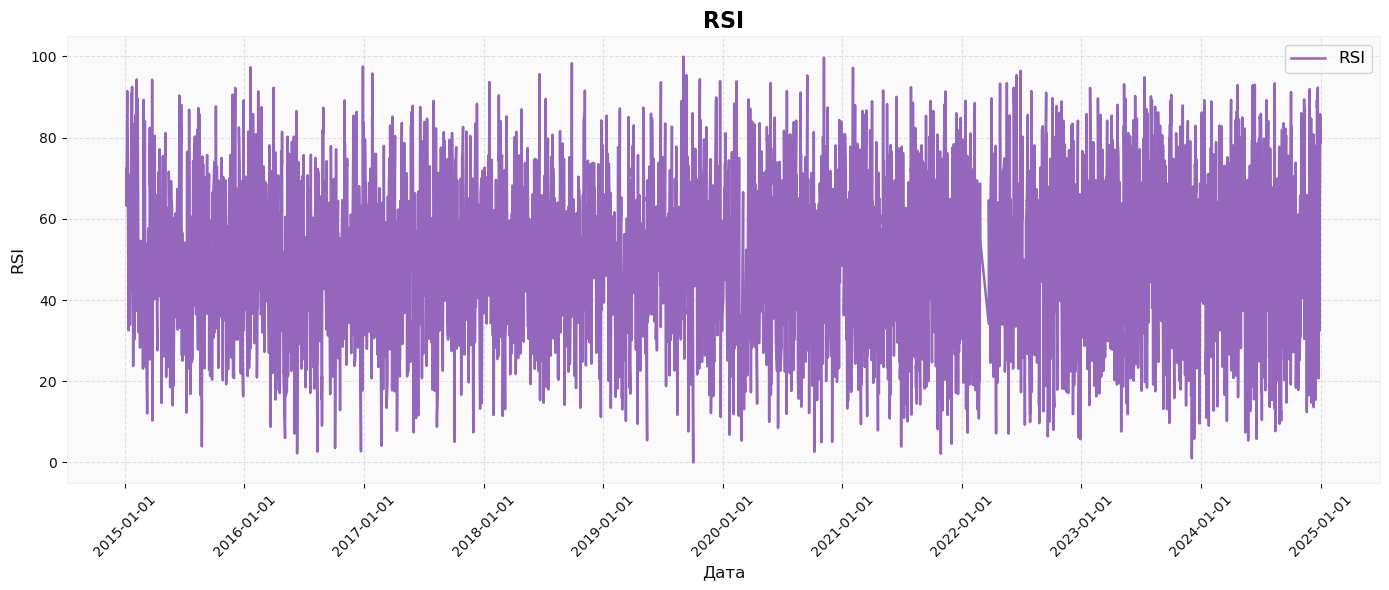

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from scipy import stats
from scipy.stats import pointbiserialr, ttest_ind, jarque_bera
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import mplfinance as mpf
from rich.console import Console
from rich.table import Table
from rich.style import Style

# Загрузка данных
file_path = r"C:\Users\Matvey\Desktop\Диплом\sngs_candles_2015-2024.csv"
df = pd.read_csv(file_path)
display(df.head())

# === 1. Анализ структуры данных ===
print("Размер датафрейма:", df.shape)
print("Типы данных:\n", df.dtypes)
print("Пропущенные значения:\n", df.isnull().sum())
print("Количество дубликатов:", df.duplicated().sum())
print("Общая информация:", df.info())

# === 2. Очистка данных ===
df = df.drop_duplicates()
df["begin"] = pd.to_datetime(df["begin"])
df["end"] = pd.to_datetime(df["end"])

assert (df["high"] >= df["low"]).all()
assert (df["high"] >= df["close"]).all()
assert (df["low"] <= df["close"]).all()
assert (df["volume"] >= 0).all()
assert (df["value"] >= 0).all()

# === 3. Добавление признаков ===
df["weekday"] = df["begin"].dt.weekday
df["month"] = df["begin"].dt.month
df["quarter"] = df["begin"].dt.quarter
df["returns"] = (df["close"] - df["open"]) / df["open"]
df["volatility"] = df["high"] - df["low"]
df["sma_10"] = df["close"].rolling(window=10).mean()
df["ema_10"] = df["close"].ewm(span=10, adjust=False).mean()

mean_price = df["close"].mean()
deviation = 0.05
upper_threshold = mean_price * (1 + deviation)
lower_threshold = mean_price * (1 - deviation)
df["above_threshold"] = df["close"] > upper_threshold
df["below_threshold"] = df["close"] < lower_threshold

delta = df["close"].diff()
gain = delta.where(delta > 0, 0).rolling(window=14).mean()
loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
rs = gain / loss
df["rsi"] = 100 - (100 / (1 + rs))

# === Корректный расчёт MACD ===
short_window = 12
long_window = 26
signal_window = 9

ema12 = df["close"].ewm(span=short_window, adjust=False).mean()
ema26 = df["close"].ewm(span=long_window, adjust=False).mean()
macd = ema12 - ema26
macd_signal = macd.ewm(span=signal_window, adjust=False).mean()

df["macd"] = macd
df["macd_signal"] = macd_signal

df["macd_crossover"] = df["macd"] > df["macd_signal"]
df["macd_crossunder"] = df["macd"] < df["macd_signal"]

macd_above_signal = ((df["macd_crossover"]) & (~df["macd_crossover"].shift(1).astype(bool))).sum()
macd_below_signal = ((df["macd_crossunder"]) & (~df["macd_crossunder"].shift(1).astype(bool))).sum()

macd_max = df["macd"].max()
macd_min = df["macd"].min()

df["bollinger_mid"] = df["close"].rolling(20).mean()
std = df["close"].rolling(20).std()
df["bollinger_upper"] = df["bollinger_mid"] + 2 * std
df["bollinger_lower"] = df["bollinger_mid"] - 2 * std

# === 4. Описательная статистика ===
print("\nОписательная статистика числовых переменных:")
print(df[["open", "high", "low", "close", "volume", "value", "returns", "volatility", "rsi", "macd"]].describe(percentiles=[.25, .5, .75]).T)

print("\nРаспределение по дням недели:")
print(df["weekday"].value_counts().sort_index())
print("\nРаспределение по месяцам:")
print(df["month"].value_counts().sort_index())

# === 5. Создание логарифмических доходностей до визуализаций ===
df["log_returns"] = np.log(df["close"] / df["close"].shift(1)) * 100

# === 6. Визуализация данных ===
plt.figure(figsize=(14, 7))
plt.plot(df["begin"], df["close"], label="Цена закрытия", color="black")
plt.axhline(mean_price, linestyle="--", color="blue", label="Среднее")
plt.axhline(upper_threshold, linestyle="--", color="red", label="Верхняя граница")
plt.axhline(lower_threshold, linestyle="--", color="green", label="Нижняя граница")
plt.fill_between(df["begin"], df["close"], upper_threshold, where=df["close"] > upper_threshold, color="red", alpha=0.3)
plt.fill_between(df["begin"], df["close"], lower_threshold, where=df["close"] < lower_threshold, color="green", alpha=0.3)
plt.legend()
plt.grid(True)
plt.title("Цена с порогами")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Визуализация MACD ===
plt.figure(figsize=(14, 7))
plt.plot(df["begin"], df["macd"], label="MACD", color="blue", linewidth=2)
plt.plot(df["begin"], df["macd_signal"], label="Сигнальная линия", color="red", linestyle="--", linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Дата", fontsize=12)
plt.ylabel("Значение MACD", fontsize=12)
plt.title("График MACD", fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.lineplot(x=df["begin"], y=df["returns"], color='blue')
plt.axhline(0, color='black', linestyle='--')
plt.title("Доходности во времени")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(df["log_returns"].dropna(), ax=axes[0], lags=40)
plot_pacf(df["log_returns"].dropna(), ax=axes[1], lags=40)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
stats.probplot(df["log_returns"].dropna(), dist="norm", plot=plt)
plt.title("QQ-график лог-доходностей")
plt.grid(True)
plt.show()

# === 6.2. Свечной график с техническими индикаторами ===
df_mpf = df.set_index("begin")
df_mpf_tail = df_mpf.tail(100)

apds = [
    mpf.make_addplot(df_mpf_tail["bollinger_upper"], color="green", label="Верхняя граница Боллинджера"),
    mpf.make_addplot(df_mpf_tail["bollinger_lower"], color="red", label="Нижняя граница Боллинджера"),
]

fig, axes = mpf.plot(
    df_mpf_tail,
    type="candle",
    style="yahoo",
    volume=True,
    mav=(10),
    addplot=apds,
    title="Свечной график с SMA и полосами Боллинджера",
    ylabel="Цена, руб.",
    ylabel_lower="Объём",
    figsize=(14, 7),
    datetime_format='%b %Y',
    xrotation=45,
    warn_too_much_data=100,
    returnfig=True
)

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    axes[0].legend(handles, labels, loc='upper left', fontsize=9)
plt.show()

# === 6.3. ADF и Jarque-Bera тесты ===
adf_result = adfuller(df["log_returns"].dropna(), autolag="AIC")
jb_result = jarque_bera(df["log_returns"].dropna())

adf_table = Table(title="ADF Тест: Проверка стационарности лог-доходностей")
adf_table.add_column("Метрика", style="cyan", no_wrap=True)
adf_table.add_column("Значение", style="magenta")
adf_table.add_row("ADF-Statistic", f"{adf_result[0]:.4f}")
adf_table.add_row("p-value", f"{adf_result[1]:.4f}")
adf_table.add_row("Used Lags", f"{adf_result[2]}")
adf_table.add_row("Number of Observations", f"{adf_result[3]}")
for key, value in adf_result[4].items():
    adf_table.add_row(f"Critical Value ({key})", f"{value:.4f}")

console = Console()
console.print(adf_table)

jb_table = Table(title="Jarque-Bera Тест: Проверка нормальности лог-доходностей")
jb_table.add_column("Метрика", style="cyan")
jb_table.add_column("Значение", style="magenta")
jb_table.add_row("JB Statistic", f"{jb_result.statistic:.4f}")
jb_table.add_row("p-value", f"{jb_result.pvalue:.4f}")
console.print(jb_table)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Список метрик и их свойств
columns = ["close", "volume", "value", "returns", "volatility", "sma_10", "ema_10", "rsi"]
titles = ["Цена закрытия", "Объем торгов", "Стоимость торгов", "Доходность", "Волатильность", "SMA 10", "EMA 10", "RSI"]
colors = ["tab:blue", "tab:purple", "tab:brown", "tab:cyan", "tab:orange", "tab:green", "tab:red", "tab:purple"]
y_labels = ["Цена (руб)", "Объем (шт)", "Стоимость (руб)", "Доходность (доли)", "Волатильность (руб)", "Цена (руб)", "Цена (руб)", "RSI"]

# Отдельный график для каждой метрики
for col, title, color, y_label in zip(columns, titles, colors, y_labels):
    plt.figure(figsize=(14, 6))
    plt.plot(df["begin"], df[col], label=title, color=color, linewidth=1.8)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel("Дата", fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(fontsize=12)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.tight_layout()
    plt.show()


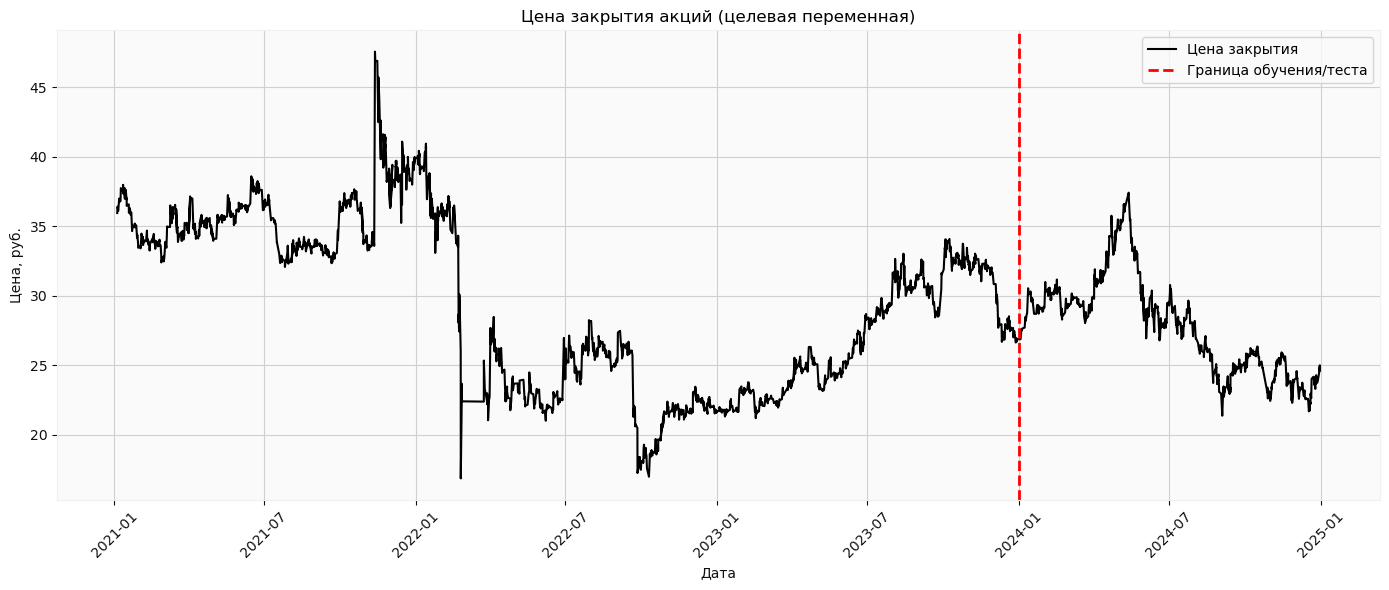

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка и фильтрация данных
file_path = r"C:\Users\Matvey\Desktop\Диплом\sngs_candles_2015-2024.csv"
df = pd.read_csv(file_path)
df["begin"] = pd.to_datetime(df["begin"])
df = df[df["begin"] >= "2021-01-01"]

# Построение графика цены закрытия
plt.figure(figsize=(14, 6))
plt.plot(df["begin"], df["close"], color="black", label="Цена закрытия")

# Вертикальная линия на границе 2024-01-01
cutoff_date = pd.to_datetime("2024-01-01")
plt.axvline(cutoff_date, color="red", linestyle="--", linewidth=2, label="Граница обучения/теста")

plt.title("Цена закрытия акций (целевая переменная)")
plt.xlabel("Дата")
plt.ylabel("Цена, руб.")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


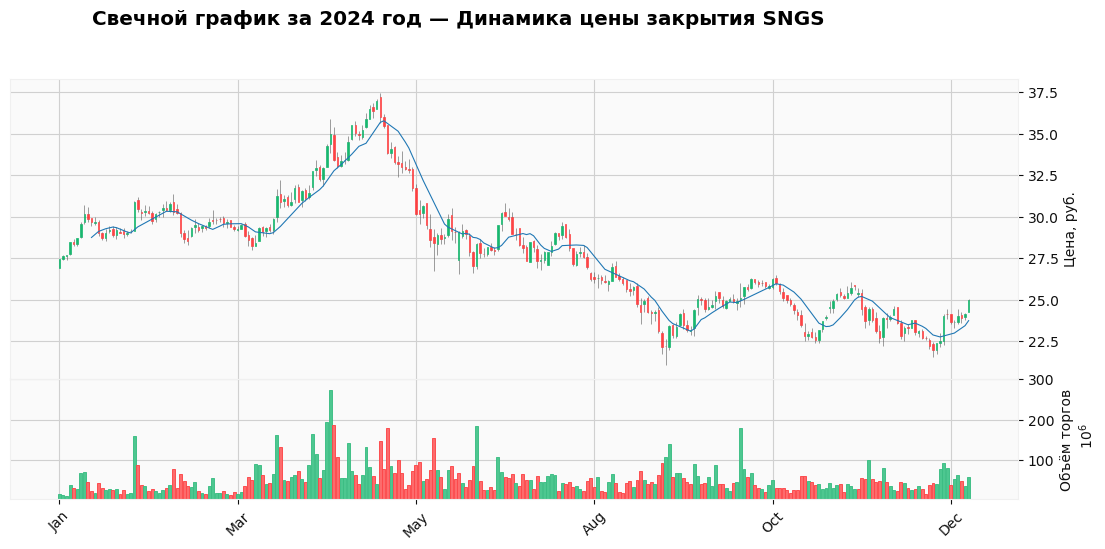

In [19]:
import pandas as pd
import mplfinance as mpf

# Убедимся, что 'begin' в формате datetime
df["begin"] = pd.to_datetime(df["begin"])

# Устанавливаем begin как индекс
df.set_index("begin", inplace=True)

# Агрегация по дням — дневные свечи
df_daily = df.resample('D').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).dropna()

# Выбор данных за 2024 год
df_2024 = df_daily.loc["2024"]

# Построение свечного графика с mplfinance
mpf.plot(
    df_2024,
    type='candle',
    style='yahoo',
    title='Свечной график за 2024 год — Динамика цены закрытия SNGS',
    ylabel='Цена, руб.',
    ylabel_lower='Объём торгов',
    volume=True,
    mav=(10),  # 10-дневная скользящая средняя
    figsize=(14, 6),
    datetime_format='%b',
    xrotation=45
)


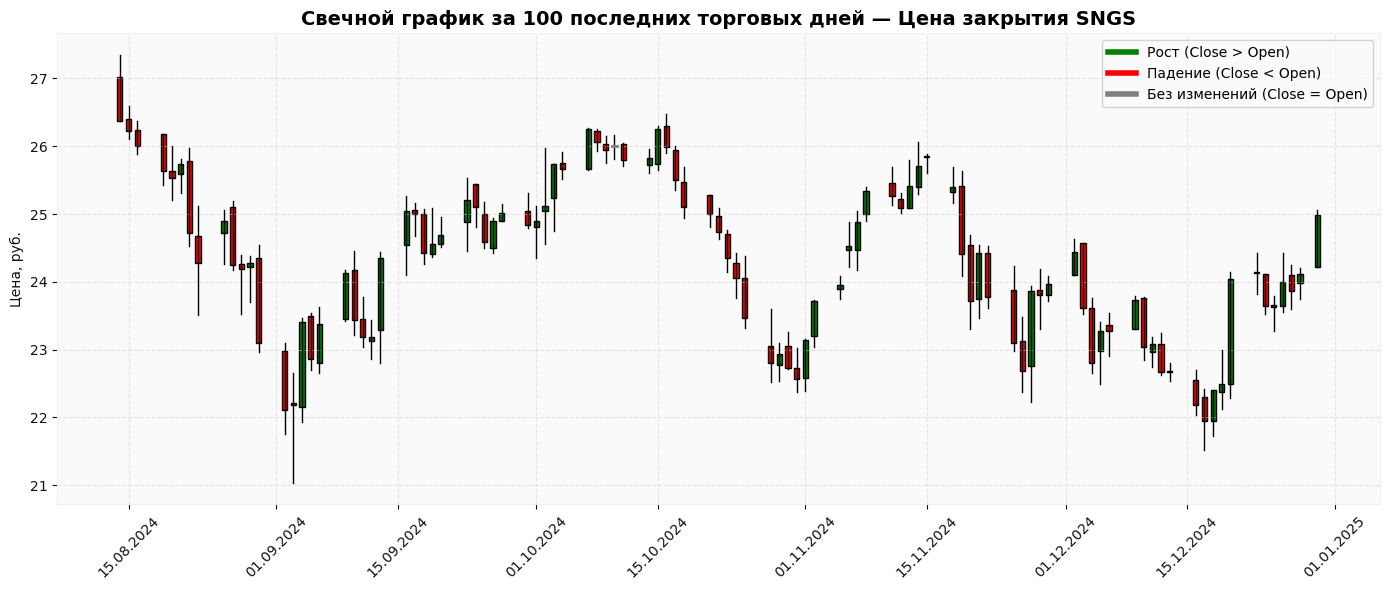

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

# Восстановим колонку 'begin' из индекса, если нужно
if 'begin' not in df.columns:
    df = df.reset_index()

# Убедимся, что дата в нужном формате
df["begin"] = pd.to_datetime(df["begin"])

# Агрегация по дням
df_daily = df.resample('D', on='begin').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).dropna()

# Отбор последних 100 торговых дней
df_tail = df_daily.tail(100)

# Преобразуем индекс в числа
x = mdates.date2num(df_tail.index)
width = 0.6

# Создание графика
fig, ax = plt.subplots(figsize=(14, 6))

for i, (idx, row) in enumerate(df_tail.iterrows()):
    color = 'green' if row['close'] > row['open'] else ('red' if row['close'] < row['open'] else 'gray')
    ax.plot([x[i], x[i]], [row['low'], row['high']], color='black', linewidth=1)
    bottom = min(row['open'], row['close'])
    height = abs(row['close'] - row['open'])
    if height == 0:
        ax.plot([x[i] - 0.3, x[i] + 0.3], [row['open'], row['open']], color=color, linewidth=2)
    else:
        ax.bar(x[i], height, width=width, bottom=bottom, color=color, edgecolor='black')

# Формат оси X — с указанием года
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y'))
plt.xticks(rotation=45)

# Добавление легенды вручную
legend_elements = [
    Line2D([0], [0], color='green', lw=4, label='Рост (Close > Open)'),
    Line2D([0], [0], color='red', lw=4, label='Падение (Close < Open)'),
    Line2D([0], [0], color='gray', lw=4, label='Без изменений (Close = Open)')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10, frameon=True)

# Оформление
ax.set_title("Свечной график за 100 последних торговых дней — Цена закрытия SNGS", fontsize=14, fontweight='bold')
ax.set_ylabel("Цена, руб.")
ax.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


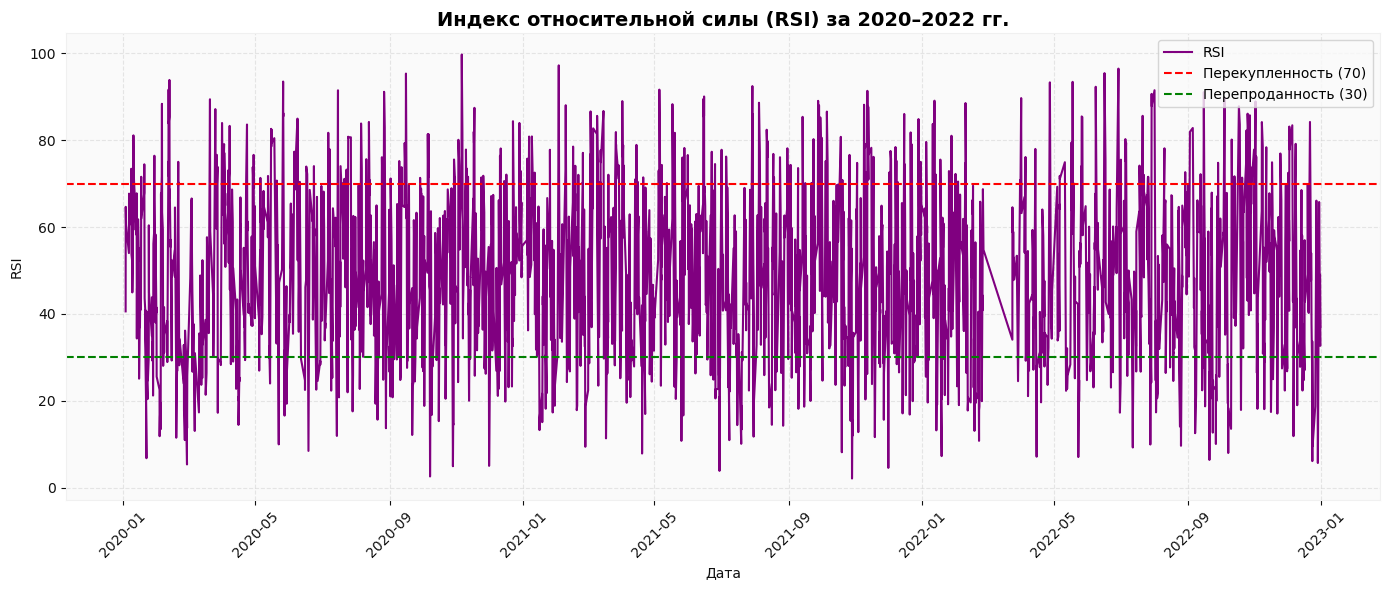

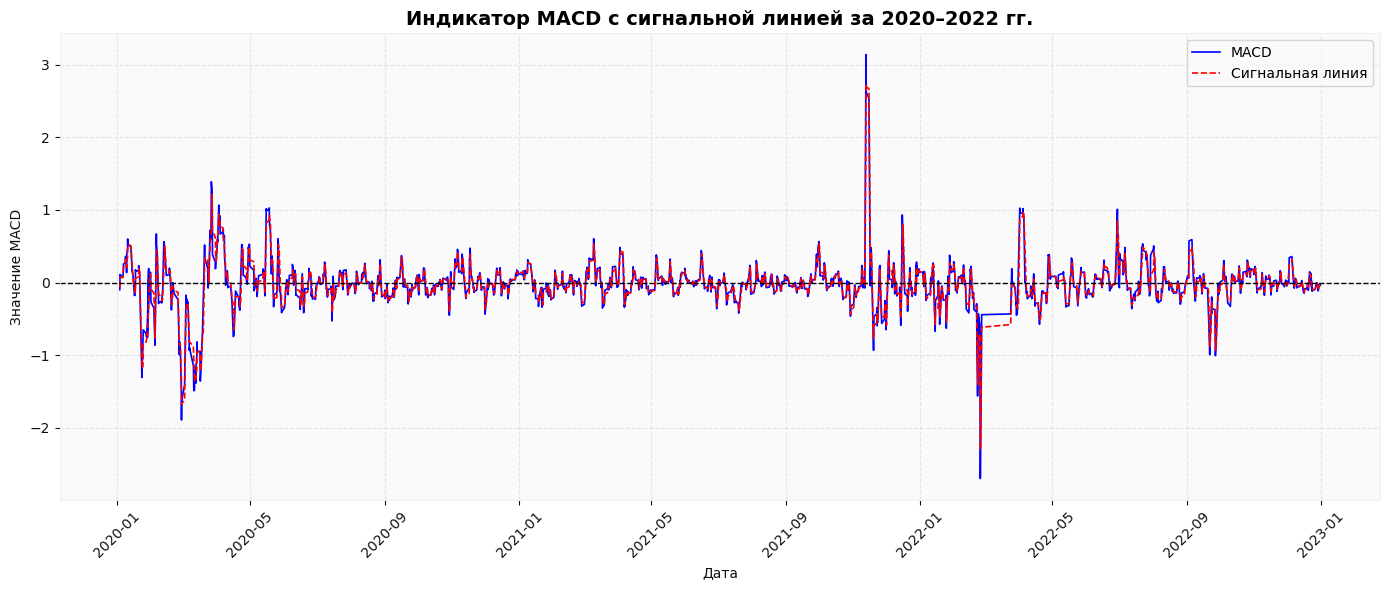

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Загрузка и подготовка данных
df = pd.read_csv("C:/Users/Matvey/Desktop/Диплом/sngs_candles_2015-2024.csv")
df["begin"] = pd.to_datetime(df["begin"])
df = df.set_index("begin")

# RSI
delta = df["close"].diff()
gain = delta.where(delta > 0, 0).rolling(window=14).mean()
loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
rs = gain / loss
df["rsi"] = 100 - (100 / (1 + rs))

# MACD
ema12 = df["close"].ewm(span=12, adjust=False).mean()
ema26 = df["close"].ewm(span=26, adjust=False).mean()
df["macd"] = ema12 - ema26
df["macd_signal"] = df["macd"].ewm(span=9, adjust=False).mean()

# Фильтрация на 2020–2022 гг.
df_period = df.loc["2020":"2022"]

# График RSI
plt.figure(figsize=(14, 6))
plt.plot(df_period.index, df_period["rsi"], label="RSI", color="purple", linewidth=1.5)
plt.axhline(70, linestyle="--", color="red", label="Перекупленность (70)")
plt.axhline(30, linestyle="--", color="green", label="Перепроданность (30)")
plt.title("Индекс относительной силы (RSI) за 2020–2022 гг.", fontsize=14, fontweight='bold')
plt.xlabel("Дата")
plt.ylabel("RSI")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# График MACD
plt.figure(figsize=(14, 6))
plt.plot(df_period.index, df_period["macd"], label="MACD", color="blue", linewidth=1.2)
plt.plot(df_period.index, df_period["macd_signal"], label="Сигнальная линия", color="red", linestyle="--", linewidth=1.2)
plt.axhline(0, linestyle="--", color="black", linewidth=1)
plt.title("Индикатор MACD с сигнальной линией за 2020–2022 гг.", fontsize=14, fontweight='bold')
plt.xlabel("Дата")
plt.ylabel("Значение MACD")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [3]:
# === Код №2: Сводная таблица только по рассчитанным метрикам из кода №1 ===

import pandas as pd
import numpy as np
from scipy.stats import jarque_bera
from statsmodels.tsa.stattools import adfuller
from rich.table import Table
from rich.console import Console
from rich.style import Style

# Загрузка данных
file_path = r"C:\Users\Matvey\Desktop\Диплом\sngs_candles_2015-2024.csv"
df = pd.read_csv(file_path)
df["begin"] = pd.to_datetime(df["begin"])
df["end"] = pd.to_datetime(df["end"])

# Добавление признаков (аналогично коду 1)
df["returns"] = (df["close"] - df["open"]) / df["open"]
df["volatility"] = df["high"] - df["low"]
df["sma_10"] = df["close"].rolling(window=10).mean()
df["ema_10"] = df["close"].ewm(span=10, adjust=False).mean()

delta = df["close"].diff()
gain = delta.where(delta > 0, 0).rolling(window=14).mean()
loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
rs = gain / loss
df["rsi"] = 100 - (100 / (1 + rs))

df["macd"] = df["close"].ewm(span=12, adjust=False).mean() - df["close"].ewm(span=26, adjust=False).mean()
df["bollinger_mid"] = df["close"].rolling(20).mean()
std = df["close"].rolling(20).std()
df["bollinger_upper"] = df["bollinger_mid"] + 2 * std
df["bollinger_lower"] = df["bollinger_mid"] - 2 * std
df["log_returns"] = np.log(df["close"] / df["close"].shift(1)) * 100

# Расчёт базовых метрик
metrics = {
    "Средняя цена закрытия": df["close"].mean(),
    "Максимальная цена": df["close"].max(),
    "Минимальная цена": df["close"].min(),
    "Средняя доходность": df["returns"].mean(),
    "Стандартное отклонение доходности": df["returns"].std(),
    "Средняя волатильность": df["volatility"].mean(),
    "Средний RSI": df["rsi"].mean(),
    "Максимальный MACD": df["macd"].max(),
    "Минимальный MACD": df["macd"].min(),
    "Средняя верхняя граница Боллинджера": df["bollinger_upper"].mean(),
    "Средняя нижняя граница Боллинджера": df["bollinger_lower"].mean(),
    "Средний объем торгов": df["volume"].mean(),
    "Средняя стоимость торгов": df["value"].mean()
}

# ADF и JB тесты
log_returns = df["log_returns"].dropna()
adf_stat, adf_pvalue, *_ = adfuller(log_returns)
jb_stat, jb_pvalue = jarque_bera(log_returns)

# Добавим их в метрики
metrics.update({
    "ADF-статистика (лог-доходности)": adf_stat,
    "p-value ADF": adf_pvalue,
    "JB-статистика (нормальность лог-доходности)": jb_stat,
    "p-value JB": jb_pvalue
})

# Вывод таблицы
console = Console()
table = Table(title="Сводная таблица по рассчитанным метрикам", title_style=Style(bold=True), show_lines=True)

table.add_column("Показатель", style="cyan", justify="left")
table.add_column("Значение", style="magenta", justify="right")

for metric, value in metrics.items():
    formatted_value = f"{value:.4f}" if isinstance(value, float) else str(value)
    table.add_row(metric, formatted_value)

console.print(table)


           Сводная таблица по рассчитанным метрикам            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Показатель                                  ┃      Значение ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Средняя цена закрытия                       │       30.9160 │
├─────────────────────────────────────────────┼───────────────┤
│ Максимальная цена                           │       54.4450 │
├─────────────────────────────────────────────┼───────────────┤
│ Минимальная цена                            │       16.8800 │
├─────────────────────────────────────────────┼───────────────┤
│ Средняя доходность                          │       -0.0000 │
├─────────────────────────────────────────────┼───────────────┤
│ Стандартное отклонение доходности           │        0.0065 │
├─────────────────────────────────────────────┼───────────────┤
│ Средняя волатильность                       │        0.2280 │
├─────────────────────────────────────────────┼───────────────┤
│ Средний RSI                                 │       49.6420 │
├─────────────────────────────────────────────┼───────────────┤
│ Максимальный MACD                           │        3.1396 │
├─────────────────────────────────────────────┼───────────────┤
│ Минимальный MACD                            │       -2.6960 │
├─────────────────────────────────────────────┼───────────────┤
│ Средняя верхняя граница Боллинджера         │       31.4604 │
├─────────────────────────────────────────────┼───────────────┤
│ Средняя нижняя граница Боллинджера          │       30.3798 │
├─────────────────────────────────────────────┼───────────────┤
│ Средний объем торгов                        │  2731508.9285 │
├─────────────────────────────────────────────┼───────────────┤
│ Средняя стоимость торгов                    │ 90325421.5647 │
├─────────────────────────────────────────────┼───────────────┤
│ ADF-статистика (лог-доходности)             │      -22.6559 │
├─────────────────────────────────────────────┼───────────────┤
│ p-value ADF                                 │        0.0000 │
├─────────────────────────────────────────────┼───────────────┤
│ JB-статистика (нормальность лог-доходности) │ 26968727.2682 │
├─────────────────────────────────────────────┼───────────────┤
│ p-value JB                                  │        0.0000 │
└─────────────────────────────────────────────┴───────────────┘

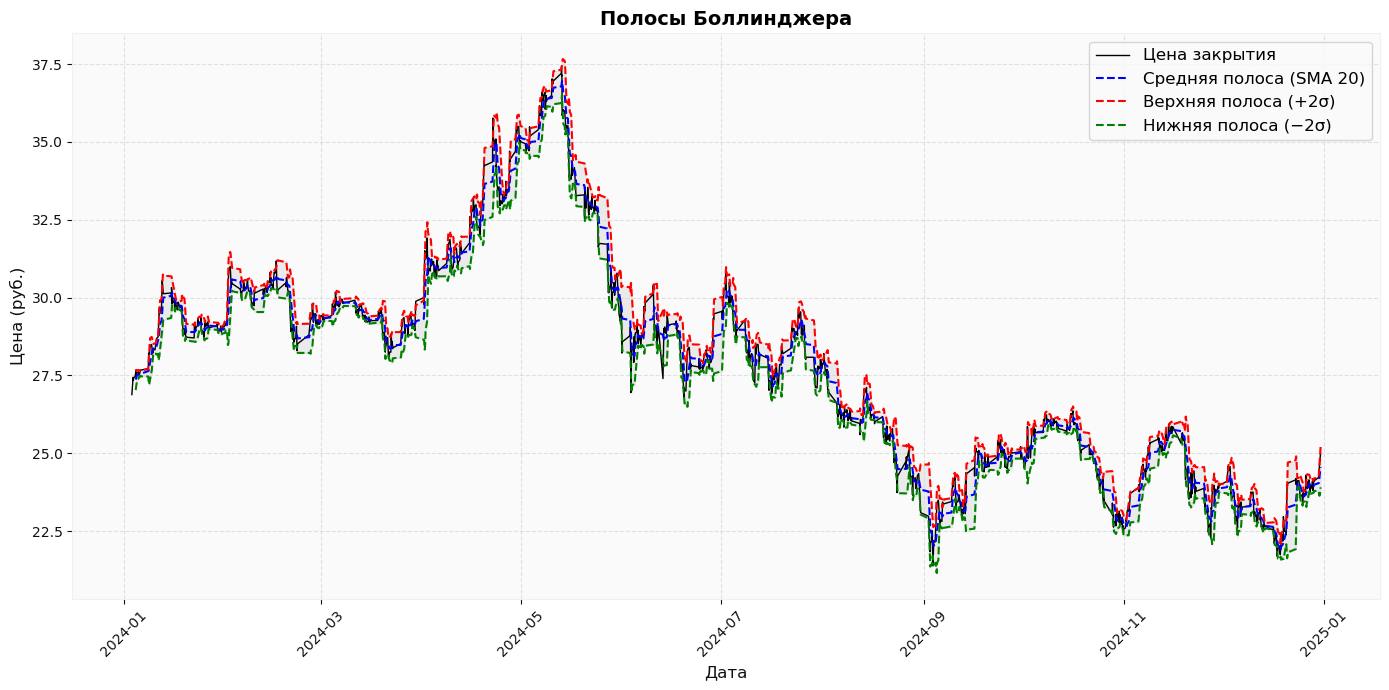

In [4]:
import matplotlib.pyplot as plt

# Фильтрация данных за 2024 год
df_2024 = df[(df["begin"] >= "2024-01-01") & (df["begin"] <= "2024-12-31")].copy()

# Пересчёт полос Боллинджера для отфильтрованных данных
df_2024["bollinger_mid"] = df_2024["close"].rolling(window=20).mean()
df_2024["bollinger_std"] = df_2024["close"].rolling(window=20).std()
df_2024["bollinger_upper"] = df_2024["bollinger_mid"] + 2 * df_2024["bollinger_std"]
df_2024["bollinger_lower"] = df_2024["bollinger_mid"] - 2 * df_2024["bollinger_std"]

# Построение графика
plt.figure(figsize=(14, 7))
plt.plot(df_2024["begin"], df_2024["close"], label="Цена закрытия", color="black", linewidth=1)
plt.plot(df_2024["begin"], df_2024["bollinger_mid"], label="Средняя полоса (SMA 20)", color="blue", linestyle="--", linewidth=1.5)
plt.plot(df_2024["begin"], df_2024["bollinger_upper"], label="Верхняя полоса (+2σ)", color="red", linestyle="--", linewidth=1.5)
plt.plot(df_2024["begin"], df_2024["bollinger_lower"], label="Нижняя полоса (−2σ)", color="green", linestyle="--", linewidth=1.5)

# Закрашиваем зону между полосами
plt.fill_between(df_2024["begin"], df_2024["bollinger_lower"], df_2024["bollinger_upper"], color="lightgray", alpha=0.4)

# Настройки оформления
plt.title("Полосы Боллинджера", fontsize=14, fontweight="bold")
plt.xlabel("Дата", fontsize=12)
plt.ylabel("Цена (руб.)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
